In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ddm
import os 
import csv
import helper
from model_definitions import ModelTtaBounds

In [77]:
for folder in ['cross_validation_9', 'cross_validation_8', 'cross_validation_4']:
    helper.merge_csv('../model_fit_results/%s' % (folder))

../model_fit_results/cross_validation_9\subj_129.csv
../model_fit_results/cross_validation_9\subj_389.csv
../model_fit_results/cross_validation_9\subj_525.csv
../model_fit_results/cross_validation_9\subj_616.csv
../model_fit_results/cross_validation_9\subj_618.csv
../model_fit_results/cross_validation_9\subj_642.csv
../model_fit_results/cross_validation_9\subj_755.csv
../model_fit_results/cross_validation_9\subj_all.csv
../model_fit_results/cross_validation_8\subj_129.csv
../model_fit_results/cross_validation_8\subj_389.csv
../model_fit_results/cross_validation_8\subj_525.csv
../model_fit_results/cross_validation_8\subj_616.csv
../model_fit_results/cross_validation_8\subj_618.csv
../model_fit_results/cross_validation_8\subj_642.csv
../model_fit_results/cross_validation_8\subj_755.csv
../model_fit_results/cross_validation_8\subj_all.csv
../model_fit_results/cross_validation_4\subj_129.csv
../model_fit_results/cross_validation_4\subj_389.csv
../model_fit_results/cross_validation_4\subj_5

In [78]:
def get_model_measures(model, condition):
    sol = model.solve(condition)
    return(condition['tta_condition'], condition['d_condition'], sol.prob_correct(), sol.mean_decision_time())

def get_model_rt_distr(model, condition, kind='cdf'):
    sol = model.solve(condition)
    return(pd.DataFrame({'tta_condition': condition['tta_condition'],
                         'd_condition':  condition['d_condition'],
                         't': model.t_domain(),
                         'rt_corr_distr': (sol.cdf_corr() if kind=='cdf' else sol.pdf_corr())/sol.prob_correct()}))

def initialize_model(param_set):
    overlay = ModelTtaBounds.OverlayNonDecisionGaussian(nondectime=param_set.ndt_location, ndsigma=param_set.ndt_scale)
    model = ddm.Model(name='TTA- and d-dependent drift and bounds and random nondecision time',
                         drift=ModelTtaBounds.DriftTtaDistance(alpha=param_set.alpha, 
                                                               beta=param_set.beta, theta=param_set.theta),
                         noise=ddm.NoiseConstant(noise=param_set.noise),
                         bound=ModelTtaBounds.BoundCollapsingTta(b_0=param_set.b_0, 
                                                                 k=param_set.k, tta_crit=param_set.tta_crit),
                         overlay=overlay, T_dur=ModelTtaBounds.T_dur)
    return(model)

def simulate_model(param_set, conditions, ret='measures'): 
    model = initialize_model(param_set)
    if ret=='measures':
        sim_result = pd.DataFrame([get_model_measures(model, condition) for condition in conditions],
                                  columns=['tta_condition', 'd_condition', 'is_turn_decision', 'RT'])
    else:
        sim_result = pd.concat([get_model_rt_distr(model, condition, kind=ret[-3:]) for condition in conditions])
    sim_result['subj_id'] = param_set.subj_id
    return sim_result

In [82]:
def save_sim_results(file_name, conditions=None, ret='measures'):
    path = '../model_fit_results/'
    file_path = os.path.join(path, file_name)
    parameters = pd.read_csv(file_path).rename(columns={'tta': 'tta_condition', 'd': 'd_condition'})
    
    if ret=='measures':
        if '9' in file_name:
            sim_results = [simulate_model(param_set, conditions, ret='measures') 
                                  for idx, param_set in parameters.iterrows()]
        else:
            sim_results = [simulate_model(param_set, [param_set[['tta_condition', 'd_condition']].to_dict()]) 
                               for idx, param_set in parameters.iterrows()]
            sim_results = pd.concat(sim_results)
        sim_results.to_csv(file_path.replace('parameters_fitted', 'measures'), index=False)
    else:
        sim_results = [simulate_model(param_set, conditions, ret=ret) for idx, param_set in parameters.iterrows()]
        sim_results = pd.concat(sim_results)
        sim_results.to_csv(file_path.replace('parameters_fitted', ret), index=False)
    return sim_results

In [80]:
conditions = [{'tta_condition': tta, 'd_condition': d} 
                       for tta in np.linspace(2,8,13)
                       for d in np.linspace(60,180,25)]

In [ ]:
save_sim_results('cross_validation_9_parameters_fitted.csv', conditions, ret='rt_cdf')

In [84]:
save_sim_results('cross_validation_9_parameters_fitted.csv', conditions, ret='rt_pdf')

,tta_condition,d_condition,t,rt_corr_distr,subj_id
0,2.0,60.0,0.000,3.511878e-18,129
1,2.0,60.0,0.005,1.031075e-17,129
2,2.0,60.0,0.010,2.984869e-17,129
3,2.0,60.0,0.015,8.520132e-17,129
4,2.0,60.0,0.020,2.398032e-16,129
...,...,...,...,...,...
496,8.0,180.0,2.480,3.101070e-121,all
497,8.0,180.0,2.485,5.336309e-122,all
498,8.0,180.0,2.490,9.130099e-123,all
499,8.0,180.0,2.495,1.553156e-123,all


In [85]:
save_sim_results('cross_validation_9_parameters_fitted.csv', conditions, ret='measures')

AttributeError: 'list' object has no attribute 'to_csv'

## Simulating for cross-validation

In [18]:
conditions = [{'tta_condition': tta, 'd_condition': d} 
                       for tta in [4,5,6]
                       for d in [90,120,150]]

In [ ]:
save_sim_results('cross_validation_8_parameters_fitted.csv', conditions, ret='measures')

In [ ]:
save_sim_results('cross_validation_4_parameters_fitted.csv', conditions, ret='measures')

# Extracting mean RT per condition

In [42]:
conditions = [{'tta_condition': 4, 'd_condition': 150}]
subj_id = 'all'
condition = conditions[0]

### Data

In [75]:
exp_data = pd.read_csv('../data/measures.csv')
between_subj_mean = exp_data[(exp_data.is_turn_decision)].groupby(['subj_id', 'tta_condition', 'd_condition']).mean()
exp_measures = between_subj_mean.reset_index()
exp_measures[(exp_measures.d_condition==condition['d_condition']) & 
             (exp_measures.tta_condition==condition['tta_condition'])].RT.mean()

0.5263569217687075

### Model measures

In [66]:
fit_results_path = '../model_fit_results'
model_measures = pd.read_csv(os.path.join(fit_results_path, 'cross_validation_9_measures.csv'))
model_measures = model_measures[(model_measures.tta_condition>=4.0) & (model_measures.tta_condition<=6.0)]
model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id)]
model_subj_d_measures[(model_subj_d_measures.d_condition==condition['d_condition']) & (model_subj_d_measures.tta_condition==condition['tta_condition'])].RT.values[0]

0.5961530683610117

### Model cross-validation

In [72]:
extra_sim_measures = save_sim_results('extra_sim\cross_validation_8\subj_all.csv', conditions, ret='measures')
extra_sim_measures.RT

0    0.63257
Name: RT, dtype: float64

### RT cdf

In [70]:
extra_sim_rt_cdf = save_sim_results('extra_sim\cross_validation_8\subj_all.csv', conditions, ret='rt_cdf')

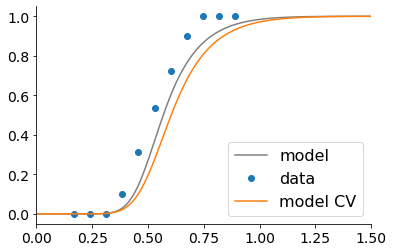

In [71]:
model_rts = pd.read_csv(os.path.join(fit_results_path, 'cross_validation_9_rt_cdf.csv'))

condition_data = exp_data[(exp_data.is_turn_decision) 
                    & (exp_data.d_condition==condition['d_condition']) 
                    & (exp_data.tta_condition==condition['tta_condition'])]

q = [0.1, 0.3, 0.5, 0.7, 0.9]
condition_quantiles = condition_data.groupby('subj_id').apply(lambda d: np.quantile(a=d.RT, q=q)).mean()
rt_range = np.linspace(condition_quantiles.min(), condition_quantiles.max(), len(q))
step = rt_range[1] - rt_range[0]
rt_grid = np.concatenate([rt_range[:3]-3*step, rt_range, rt_range[-3:]+step*3])
vincentized_cdf = np.interp(rt_grid, condition_quantiles, q, left=0, right=1)

condition_rts = model_rts[(model_rts.subj_id=='all') 
                    & (model_rts.d_condition==condition['d_condition']) 
                    & (model_rts.tta_condition==condition['tta_condition'])]

fig, ax = plt.subplots()
ax.plot(condition_rts.t, condition_rts.rt_corr_pdf, label='model', color='grey')
ax.plot(rt_grid, vincentized_cdf, ls='', marker='o', label='data')
ax.plot(extra_sim_rt_cdf.t, extra_sim_rt_cdf.rt_corr_pdf, label='model CV')
ax.set_xlim((0.0, 1.5))
ax.legend()